# Catalogue 
-------------

**- Calcium Data Preprocessing**

**- Hidden Markov Model Using Forward-Backward Algorithm**
1. Description
2. Realization
3. Implement HMM Algorithms 
4. Simulation

**- Actual Data, Shuffle Data and The Trained Models**
1. Data Shuffling
2. Learn Models in Origin PBE Data and Shuffle Data
3. Plottings

<font color=green>**Summary** This project aims at replicating results from the paper "**Uncovering temporal structure in hippocampal output patterns**" (Maboudi et al., 2018), while in this project calcium traces data were used rather than LFP data. In this case, length of time bin was defined as 0.5s rather than 20ms. I have implemented the hidden Markov model algorithms as a model 'GaussHMM', but it just worked well for data with small size. For actual data, I use 'hmmlearn.hmm.GaussianHMM'. The main reason 'GaussHMM' doesn't work well with big data should be that the value of probability after many recursions becomes very small, so computing them always result in overflow warnings. The solution may be compute them in log scale. Had tried it but still not work well. Maybe other tricks are needed.

-------------

# Calcium Data Preprocessing
-----------

**1. Smooth and z-score calcium traces (for the ease of K-means initialization) and smooth speed data.**

**2. Compute calcium trace summation across all cells (SDF).** 

Segments where SDF cross mean and the maximum SDF cross mean+std were detected as population burst event candidates. After checking the SDF and the corresponding speed, few PBE candidates occur during immobile time. So we use PBEs during running time in this project.

**3. Exclude population burst event candidates during which the rat is immobile or which last less than 2 s.**

**4. Bin calcium traces into 0.5s time bin.** 

$E$ denotes the total number of detected population burst events. $N$ denotes the number of neurons.
In the $e^{th}$ burst events, $e=1,2,...,E$, calcium trantients $x_t$, an $N$-dimensional vector, $t=1,2,...,T_e$, were computed as the summation within the 0.2 s time bin. The binned calcium trantients of population burst events are concatenated and stored in a ($T_{all}\times N$) array `PBEs`, where $T_{all}=T_1+T_2+...+T_E$ is the total number of observations of calcium transients. Length of event $e$ is stored in a $E$-dimensional vector `lengths`.

In [1]:
import numpy as np
from sklearn.cluster import KMeans
import math
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import savgol_filter
%matplotlib inline

In [58]:
data = loadmat('/Users/daiyiluo/Downloads/a529-20150225.mat')
traces = data['Tr1b']
speed = data['Speed']
MovT = data['MovT']

# filter and z-score calcium traces
traces = savgol_filter(traces, window_length=7, polyorder=1)
traces_z = (traces-np.min(traces, axis=1)[:,np.newaxis])/(np.max(traces, axis=1)-np.min(traces, axis=1))[:, np.newaxis]
# filter speed
speed = speed.squeeze()
speed_fil = savgol_filter(speed, window_length=11, polyorder=1)


In [59]:

## detect PBEs ##

# compute total calcium trace across all cells SDF
SDF = np.sum(traces_z, axis=0)
SDF = savgol_filter(SDF, window_length=11, polyorder=1)
mean = np.mean(SDF)
thr = np.mean(SDF)+np.std(SDF)

# detect SDF segments (PBEs) above mean(SDF)
sdf_cmi = np.append(np.where(SDF>mean)[0], len(SDF)+1)  #sdf cross mean idx
sdf_cmci = np.where(np.diff(sdf_cmi)>1)[0] #sdf cross mean component idx
sdf_end = sdf_cmi[sdf_cmci]
sdf_start = np.insert(sdf_cmi[sdf_cmci[:-1]+1], values=sdf_cmi[0], obj=0)

# exclude PBEs whose maximum are less than SDF threshold (mean+std)
events_can = [] # event candidates 
events_can_idx = [] 
idx_all = np.arange(len(SDF))
for i in range(len(sdf_start)):
    event = SDF[sdf_start[i]:sdf_end[i]+1]
    if np.max(event)>thr:
        events_can.append(event)
        events_can_idx.append(idx_all[sdf_start[i]:sdf_end[i]+1])

# exclude PBEs during which immobile time > 0.2 total time or total time < 2s
total_time_thr = 2/0.1
events = []
events_idx = []
for i in range(len(events_can)):
    event_sp = speed_fil[events_can_idx[i]]
    ratio = np.sum(event_sp<0.2)/len(event_sp)
    l = len(events_can[i])
    if (ratio<0.2)&(l>total_time_thr):
        events.append(events_can[i])
        events_idx.append(events_can_idx[i])
        
del events_can
del events_can_idx

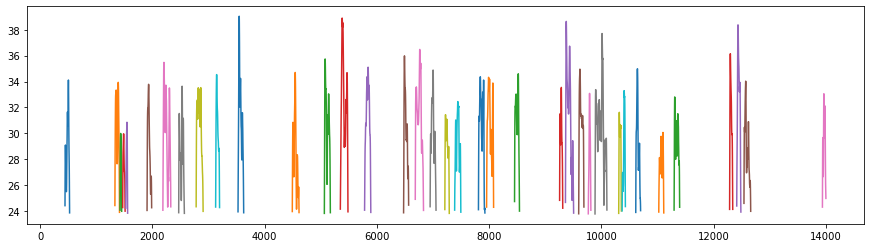

In [61]:
plt.figure(figsize=(15,4))
for i in range(len(events)):
    plt.plot(events_idx[i],events[i])

In [6]:
def bin_PBEs(events_idx, traces_z, timebin):
    lengths = []
    PBE_bins = []
    for idx_all in events_idx:
        l = len(idx_all)
        ex = l%timebin
        if ex!=0:
            idx_all = idx_all[:-ex]
            l -= ex

        lengths.append(int(l/timebin))
        PBE = traces_z[:,idx_all]
        PBE_bin = np.zeros((traces_z.shape[0], int(l/timebin)))
        for i in range(timebin):
            PBE_bin += PBE[:,np.arange(i,l,timebin)]

        PBE_bins.append(PBE_bin)
        
    return PBE_bins, lengths

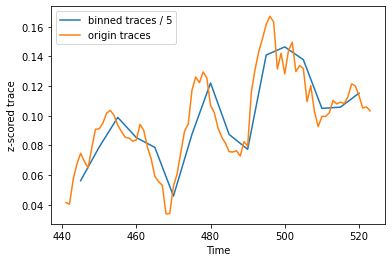

In [62]:
timebin=5
PBE_bin, lengths = bin_PBEs(events_idx, traces_z, timebin=timebin) # timewindow = 0.2s: 0.1s*2
%matplotlib inline
e = 0 # eth PBE
n = 7 # nth neuron
plt.figure()
plt.plot(events_idx[e][timebin-1::timebin],PBE_bin[e][n,:]/timebin, label = 'binned traces / 5')
plt.plot(events_idx[e],traces_z[n,events_idx[e]], label = 'origin traces')
plt.xlabel('Time')
plt.ylabel('z-scored trace')
plt.legend()

In [11]:
PBEs = np.concatenate(PBE_bin,axis=1)
lengths = np.array(lengths)
seg_end = np.cumsum(lengths)
seg_start = np.insert(seg_end[:-1], 0, 0)

In [68]:
print(f'Shape of lengths: {lengths.shape}')
print(f'Shape of seg_start: {seg_start.shape}')
print(f'Shape of PBEs: {PBEs.shape}')

Shape of lengths: (37,)
Shape of seg_start: (37,)
Shape of PBEs: (166, 687)


In [15]:
np.savez('/Users/daiyiluo/Documents/ELEC 548/final_data_5.npz', PBEs=PBEs, lengths=lengths, seg_start=seg_start)

# Hidden Markov Model Using Forward-Backward Algorithm
------------
## 1. Description 
In this HMM, there are $K$ unobserved discrete latent states $z$. The latent state $z_t$ evolves through time $t$ according to a first order Markov process, $t=1, 2, ..., T$. Parameters $\theta=\{ \mathbf{A}, \pi, \mu, \Sigma \}$.

<img src="HMM.png">

### 1.1. Transition Matrix $\mathbf{A}$
The temporal evolution of the latent state is described by the $K\times K$ matrix $\mathbf{A}$, whose elements ${a_{ij}=Pr\left(z_{t+1}=j \vert z_t = i \right)}$.

### 1.2. Observation Model ${\mathcal{N}} (\mu,\Sigma)$
During each time bin of an event, we model the $N$-dimensional vector of binned calcium trantient from the ensemble of $N$ neurons at time $t$, $X_t$, as a Gaussian process. For each state $i$, we model neuron $n$ as independently firing according to a Gaussian process $Pr(x_{nt}\vert z_t=i) \thicksim {\mathcal{N}} (\mu_{ni},\Sigma_{ni})$.
$$Pr(x_{nt}\vert z_t=i)=\frac{1}{\sqrt{2\pi\Sigma_{ni}}}e^{-\frac{(x_{nt}-\mu_{ni})^2}{2\Sigma_{ni}}}$$

### 1.3. Initial State $\pi$
The initial state for a given event is an $N$-dimensional vector $\mathbf{\pi}$ whose elements $\pi_i=Pr(z_1=i)$.

## 2. Realization
### 2.1. Initialize $\mathbf{A}$, $\pi$, $\mu$ and $\Sigma$

**2.1.1.** Given the constrain that $0\leq \pi_i, A_{ij} \leq 1$, and $\sum_{i}^K \pi_i = 1$, $\sum_{j}^K A_{ij} = 1$. We initialize $\mathbf{A}$ and $\mathbf{\pi}$ uniformly.

**2.1.2.** Manually define number of states $K$ and then run K-means first, deviding the binned calcium trantients into $K$ groups. Initialize $\Sigma$ and $\mu$ basing on the $K$ groups.

### 2.2. Estimation Step
**2.2.1.** Run forward $\alpha$ recursion and backward $\beta$ recursion.
$$\alpha(z_{tj})=Pr(x_1, ..., x_t, z_{tj})=Pr(x_t \vert z_{tj})\sum_{i=1}^K\alpha(z_{t-1,i})Pr(z_{tj}\vert z_{t-1,i})$$
$$\beta(z_{tj})=Pr(x_{t+1}, ..., x_T \vert z_{tj})=\sum_{i=1}^K\beta(z_{t+1,i})Pr(x_{t+1}\vert z_{t+1,i})Pr(z_{t+1,i}\vert z_{t,j})$$
where $t$ denotes the $t$th observation and $i,j$ denote the $i$th, $j$th states. And $\alpha(z_{1,j})=Pr(x_1, z_{1,j})=Pr(z_{1,j})Pr(x_1\vert z_{1,j})$, $\beta(z_{T,1})=1$.

**2.2.2.** Evaluate marginal distribution of $z_t$, $\gamma(z_t)$, and joint posterior distribution of $z_{t-1}$ and $z_t$, $\xi(z_{t-1}, z_t)$:

$$\gamma(z_t)=Pr(z_t\vert X, \theta^{old})=\frac{\alpha(z_{t})\beta(z_{t})}{Pr(X)}$$

$$\xi(z_{t-1}, z_t)=Pr(z_{t-1}, z_t\vert X, \theta^{old})=\frac{\alpha(z_{t-1})Pr(x_t\vert z_t)Pr(z_t\vert z_{t-1})\beta(z_t)}{Pr(X)}$$

$$Pr(X) = \sum_{z_t} \alpha(z_t)$$

### 2.3. Modification Step
Maximize likelihood function with respect to $\theta$ and treat $\gamma(z_t)$ and $\xi(z_{t-1}, z_t)$ as constant.
$$\pi_k=\frac{\gamma(z_{1k})}{\sum_{j=1}^K \gamma(z_{1j})}$$

$$A_{jk}=\frac{\sum_{t=2}^T \xi(z_{t-1,j}, z_{tk})}{\sum_{l=2}^K \sum_{t=2}^T \xi(z_{t-1,j}, z_{tl})}$$

$$\mu_k=\frac{\sum_{t=1}^T \gamma(z_{tk})x_t}{\sum_{t=1}^T \gamma(z_{tk})}$$

$$\Sigma_k=\frac{\sum_{t=1}^T \gamma(z_{tk})(x_t-\mu_k)(x_t-\mu_k)^T}{\sum_{t=1}^T \gamma(z_{tk})}$$

## 3. Implement HMM Algorithm 

Though not work well with data of large size (That is, not work well with the actual data) 😅


**Some matrix operation details:**


$\xi(t)_{ij}=\xi(z_{t-1,i}, z_{t,j})=[\alpha(z_{t-1,i})Pr(z_{tj}\vert z_{t-1,i})][Pr(x_t\vert z_{tj})\beta(z_{tj})]$

$$\xi(t) = \left[ \begin{matrix} \alpha(z_{t-1,1}) \\ \alpha(z_{t-1,2}) \\ ... \\ \alpha(z_{t-1,K}) \end{matrix} \right] \times \left[ \begin{matrix} a_{11} & a_{12} & ... & a_{1K} \\ a_{21} & a_{22} & ... & a_{2K} \\ \vdots & \vdots & \ddots & \vdots \\ a_{K1} & a_{K2} & ... & a_{KK} \end{matrix} \right] \times \left[ \begin{matrix} Pr(x_t\vert z_{t,1}) & Pr(x_t\vert z_{t,2}) & ... & Pr(x_t\vert z_{t,K}) \end{matrix} \right] \times \left[ \begin{matrix} \beta(z_{t,1}) & \beta(z_{t,2}) & ... & \beta(z_{t,K}) \end{matrix} \right]$$


In [29]:
def P_Gauss(xt, mu, sigma):
    """ Parameters
    -----------
    xt : array of the shape (n_features,)
    mu : array of the shape (n_features, n_states)
    sigma : array of the shape (n_features, n_states)
    
    Returns
    -----------
    P(xt|mu,sigma) of shape (n_states,)
    """
    xt = xt.reshape((xt.shape[0],1))
    p = np.exp(-(xt-mu)**2/(2*sigma))/(np.sqrt(2*math.pi*sigma))
    
    return(np.product(p, axis=0))

In [30]:
class GausHMM():
    
    def __init__(self, n_states=2, tol=1, max_iter=100):
        self.n_states = n_states
        self.tol = tol
        self.max_iter = max_iter
        self.likelihood = 0
        self.likelihood_log = [1]
        
        
    def initialize(self, X, seg_start = np.array([0])):
        """ Parameters
        -----------
        X : array of the shape (n_all_samples T, n_features N) 
        
        Returns
        -----------
        self.pi : start states, array of the shape (n_states K, n_segments E)
        self.A : transition matrix, array of the shape (n_states K, n_states K)
        self.mu : mean of Gaussian observation model, array of the shape (n_features N, n_states K)
        self.Sigma : variance of Gaussian observation model, array of the shape (n_features N, n_states K)
        
        """
        
        K = self.n_states
        E = len(seg_start)
        
        # uniformly initialize A and pi
        self.pi = np.ones((K, E))/K
        self.A = np.ones((K, K))/K
        
        # initialize mu and Sigma by K-means
        kmeans = KMeans(n_clusters=K)
        kmeans.fit(X) # X of the shape (n_samples, n_features)
        self.mu = kmeans.cluster_centers_.T # mu of the shape (n_features, n_states)
        self.Sigma = np.array([np.var(X[kmeans.labels_==i], axis=0) for i in range(K)]).T
        
    
    
    def forward_backward_recur(self, X_seg, seg_num=0):
        """ Parameters
        -----------
        X_seg : array of the shape (n_samples T_e, n_features N) 
        
        Returns
        -----------
        alpha : forward lattice, of shape (n_states K, n_samples T_e) 
        beta : backward lattice, of shape (n_states K, n_samples T_e) 
        P_x_given_z : likelihood of X_seg given states z, of shape (n_states K, n_samples T_e) 
        
        """
        T = X_seg.shape[0]
        
        P_x_given_z = np.zeros((self.n_states, T))
        for t in range(0,T):
            P_x_given_z[:,t] = P_Gauss(X_seg[t,:], self.mu, self.Sigma)
        
        alpha = np.zeros((self.n_states, T)) # of shape (K, T)
        beta = np.zeros((self.n_states, T)) # of shape (K, T)
        alpha[:,0] = self.pi[:,seg_num] * P_x_given_z[:,0]
        beta[:,-1] = 1   
        for t in range(1,T):
            alpha[:,t] = P_x_given_z[:,t]*np.dot(alpha[:,t-1].T, self.A).T
            beta[:,-t-1] = self.A.dot(beta[:,-t]*P_x_given_z[:,-t])
            
        return alpha, beta, P_x_given_z

        
        
    def estimate(self, alpha, beta, P_x_given_z):
        """Returns
        -----------
        gamma : marginal probability of state z_t, of shape (n_states K, n_samples T_e)
        xi : joint distribution of z_{t-1} and z_t, of shape (n_states K, n_states K, n_samples T_e-1)
        likelihood : likelihood of X_seg, scaler
        
        """
        likelihood = np.sum(alpha[:,-1])
        gamma = alpha*beta
        xi = self.A[:,:,np.newaxis]*alpha[:,np.newaxis,:-1]*beta[np.newaxis,:,1:]*P_x_given_z[np.newaxis,:,1:]
        return gamma, xi, likelihood

    
    
    def M_step(self, X):
        self.A = np.sum(self.xi, axis=2)/np.sum(self.xi, axis=(1,2)).reshape((self.n_states,1))
        self.mu = (np.dot(self.gamma, X)/np.sum(self.gamma, axis=1)[:,np.newaxis]).T
        for i in range(self.n_states):
            diff_X_sq = (X-self.mu[:,i][np.newaxis,:])**2
            self.Sigma[:, i] = np.dot(self.gamma[i,:][np.newaxis,:], diff_X_sq)/np.sum(self.gamma[i,:]).T
        
        
        
        
    def fit(self, X, seg_start = np.array([0])):
        """Parameters
        -----------
        X : array of the shape (n_all_samples T, n_features N) 
        seg_start : start indice of the segments of the shape (n_segments E,)
        """
        # Initialization
        self.initialize(X, seg_start)
        
        # Estimation Step carried out segment by segment
        E = len(seg_start)
        print(f'{E} segments detected.')
        seg_start = np.concatenate((seg_start, np.array([X.shape[0]])))
        
        for count in range(self.max_iter):
            self.gamma=np.array([]).reshape((self.n_states,0))
            self.xi=np.array([]).reshape((self.n_states,self.n_states,0))
        
            for i in range(E):
                # estimate gamma, xi, likelihood of this segment 
                alpha, beta, P_x_given_z = self.forward_backward_recur(X[seg_start[i]:seg_start[i+1]], i)
                gamma, xi, likelihood = self.estimate(alpha, beta, P_x_given_z)
                self.pi[:,i] = gamma[:,0]/np.sum(gamma[:,0]) # update pi for this segment

                # pool the estimations together with previous segments
                self.gamma = np.concatenate((self.gamma, gamma), axis=1) # would end up with shape (n_states K, n_samples T_all)
                self.xi = np.concatenate((self.xi, xi), axis=2) # would end up with shape (n_states K, n_states K, n_samples T_all-E)
                self.likelihood += likelihood # end up to be a scaler

            self.likelihood_log.append(np.log(self.likelihood))
            self.M_step(X)
            
            if abs(self.likelihood_log[-1]-self.likelihood_log[-2])<self.tol:
                break


**Reorder transmat for visualization:**

1. Assign the first index to the state with the highest initial probability
2. Add states based on the most probable state transitions

In [40]:
def switch_rc(T, i, count):
    """Switch i_th column and row to count_th column and row"""
    t = T[:,i].copy()
    T[:,i]=T[:,count].copy()
    T[:,count] = t.copy()
    t = T[i,:].copy()
    T[i,:]=T[count,:].copy()
    T[count,:] = t.copy()
    return T
    
    
def order_transmat(transmat, startprob):
    """Reorder transmat"""
    T = transmat.copy()
    T = np.vstack((T,np.arange(T.shape[0])))
    i = np.argmax(startprob) # the ith neuron to put to count th
    
    count = 0
    T = switch_rc(T, i, count)

    for count in range(1,T.shape[1]):
        i = np.argmax(T[count-1,count:])+count
        T = switch_rc(T, i, count)
    
    Tr = T[:-1,:]
    order = T[-1,:]
        
    return Tr, order

## 4. Simulation

Learn HMM from generated Gaussian random process. Simulated data is generated step by step with defined transition matrix $A$, $\mu$ and $\Sigma$. Simulate data of small size run well with the model.

In [36]:
A = np.array([[0.7,0.1,0.05,0.15],
              [0.01, 0.6, 0.3, 0.09],
              [0.05, 0.1, 0.8, 0.05], 
              [0.17, 0.23, 0.25, 0.35]])
mu=np.array([[10,9,0,4],[5,13,2,0]])
sigma=np.array([[1,3,1,2],[2,2,1,3]])

X = np.zeros((100,2))
Z = np.zeros(100, dtype='int64')
Z[0] = 2
X[0,:] = np.random.normal(loc=mu[:,Z[0]],scale=sigma[:,Z[0]])
for i in range(1,100):
    Z[i] = np.random.choice(np.arange(4), p = A[Z[i-1],:], replace=True)
    X[i,:] = np.random.normal(loc=mu[:,Z[i]],scale=sigma[:,Z[i]])

In [47]:
ghmm=GausHMM(n_states=4)
ghmm.fit(X)

1 segments detected.


Text(0.5, 1.05, 'Learned A')

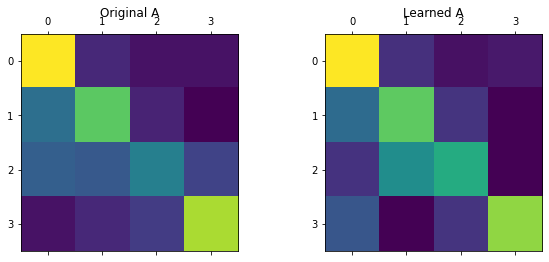

In [56]:
plt.figure(figsize=(10,4))
ax1 = plt.subplot(1,2,1)
Ao,order=order_transmat(A, np.array([0,0,1,0]))
ax1.matshow(Ao)
plt.title('Original A')
ax2 = plt.subplot(1,2,2)
Ao1,order1=order_transmat(ghmm.A, ghmm.pi)
ax2.matshow(Ao1)
plt.title('Learned A')

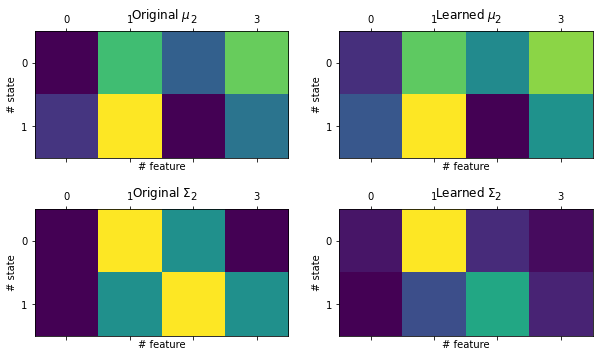

In [55]:
plt.figure(figsize=(10,6))
ax1 = plt.subplot(2,2,1)
ax1.matshow(mu[:,order.astype('int64')])
plt.xlabel('# feature')
plt.ylabel('# state')
plt.title('Original $\mu$')

ax2 = plt.subplot(2,2,2)
ax2.matshow(ghmm.mu[:, order1.astype('int64')])
plt.xlabel('# feature')
plt.ylabel('# state')
plt.title('Learned $\mu$')

ax3 = plt.subplot(2,2,3)
ax3.matshow(sigma[:,order.astype('int64')])
plt.xlabel('# feature')
plt.ylabel('# state')
plt.title('Original $\Sigma$')

ax4 = plt.subplot(2,2,4)
ax4.matshow(ghmm.Sigma[:, order1.astype('int64')])
plt.xlabel('# feature')
plt.ylabel('# state')
plt.title('Learned $\Sigma$')

plt.show()

# Actual Data, Shuffle Data and The Trained Models
---------

## 1. Data Shuffling

In [67]:
data = np.load('/Users/daiyiluo/Documents/ELEC 548/final_data_5.npz')
PBEs = data['PBEs']
lengths = data['lengths']
seg_start = data['seg_start']

In [17]:
def show_shuffle(PBEs_TemS, PBEs, shuffle, seg_num=9, neuron=0):
    plt.plot((PBEs_TemS[neuron:neuron+10,seg_start[seg_num]:seg_start[seg_num]+lengths[seg_num]]+np.arange(neuron,neuron+10)[:,np.newaxis]).T, 'g')
    plt.plot((PBEs[neuron:neuron+10,seg_start[seg_num]:seg_start[seg_num]+lengths[seg_num]]+np.arange(neuron,neuron+10)[:,np.newaxis]).T, 'k')
    plt.title(f'The {seg_num}th PBE \n Green: {shuffle}')
    plt.ylabel('Neurons')
    plt.xlabel('Time')

### 1.1. Temporal shuffle

In [52]:
# temporal shuffle - unit-independent circular permuted
PBEs_TemS = np.zeros_like(PBEs)
for i in range(len(lengths)):
    events = PBEs[:,seg_start[i]:seg_start[i]+lengths[i]]
    for n in range(events.shape[0]):
        event = events[n, :]
        c = np.random.choice(lengths[i])
        PBEs_TemS[n,seg_start[i]:seg_start[i]+lengths[i]] = np.concatenate((event[c:], event[:c]))

### 1.2. Time Swap Shuffle

In [53]:
PBEs_TSS = np.zeros_like(PBEs)
for i in range(len(lengths)):
    l = lengths[i]
    events = PBEs[:,seg_start[i]:seg_start[i]+l]
    c = np.random.choice(l,size=(l),replace=False)
    PBEs_TSS[:,seg_start[i]:seg_start[i]+l] = events[:, c]

### 1.3. Gaussian Surrogate Shuffle

Estimate each unit’s mean firing rate and standard deviation across all PBEs, and then produce surrogate PBEs from independent Gaussian simulations according to each unit’s mean firing rate and standard deviation.

In [54]:
mean = np.mean(PBEs, axis = 1)
std = np.std(PBEs, axis = 1)
PBEs_GSS = np.zeros_like(PBEs)
l = PBEs.shape[1]
for i in range(mean.shape[0]):
    PBEs_GSS[i, :] = np.random.normal(mean[i], std[i], size=(l,))

### Show Shuffled Data

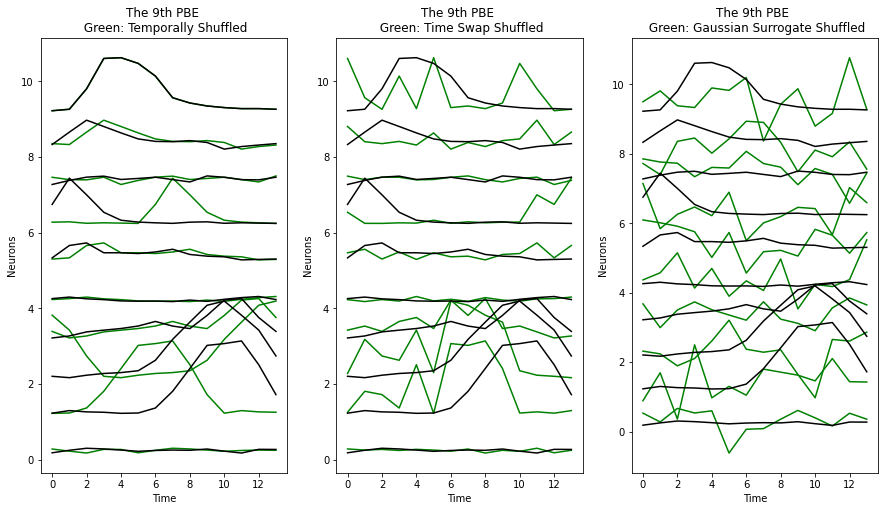

In [55]:
plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
show_shuffle(PBEs_TemS, PBEs, shuffle = 'Temporally Shuffled')
plt.subplot(1,3,2)
show_shuffle(PBEs_TSS, PBEs, shuffle = 'Time Swap Shuffled')
plt.subplot(1,3,3)
show_shuffle(PBEs_GSS, PBEs, shuffle = 'Gaussian Surrogate Shuffled')

## 2. Learn Models in Origin PBE Data and Shuffle Data

In [22]:
import hmmlearn.hmm

In [56]:
# original data
origin = hmmlearn.hmm.GaussianHMM(n_components=20) 
origin.fit(PBEs.T, lengths=lengths)

# temporal shuffle data
TemS = hmmlearn.hmm.GaussianHMM(n_components=20) 
TemS.fit(PBEs_TemS.T, lengths=lengths)

# time swap shuffle data
TSS = hmmlearn.hmm.GaussianHMM(n_components=20)
TSS.fit(PBEs_TSS.T, lengths=lengths)

# Gaussian surrogate shuffle data
GSS = hmmlearn.hmm.GaussianHMM(n_components=20)
GSS.fit(PBEs_GSS.T, lengths=lengths)

GaussianHMM(n_components=20)

## 3. Plottings
### 3.1. Reorder and show transition matrix and means

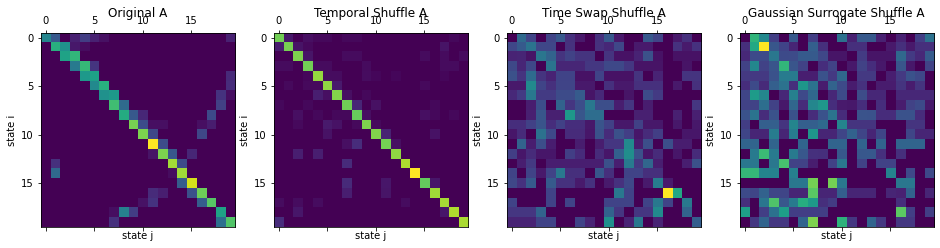

In [57]:
T_ori, order_ori = order_transmat(origin.transmat_, origin.startprob_)
T_TemS, order_TemS = order_transmat(TemS.transmat_, TemS.startprob_)
T_TSS, order_TSS = order_transmat(TSS.transmat_, TSS.startprob_)
T_GSS, order_GSS = order_transmat(GSS.transmat_, GSS.startprob_)

plt.figure(figsize=(16,12))
ax1 = plt.subplot(1,4,1)
ax1.matshow(T_ori)
plt.xlabel('state j')
plt.ylabel('state i')
plt.title('Original A')
ax2 = plt.subplot(1,4,2)
ax2.matshow(T_TemS)
plt.xlabel('state j')
plt.ylabel('state i')
plt.title('Temporal Shuffle A')
ax3 = plt.subplot(1,4,3)
ax3.matshow(T_TSS)
plt.xlabel('state j')
plt.ylabel('state i')
plt.title('Time Swap Shuffle A')
ax4 = plt.subplot(1,4,4)
ax4.matshow(T_GSS)
plt.xlabel('state j')
plt.ylabel('state i')
plt.title('Gaussian Surrogate Shuffle A')

plt.show()

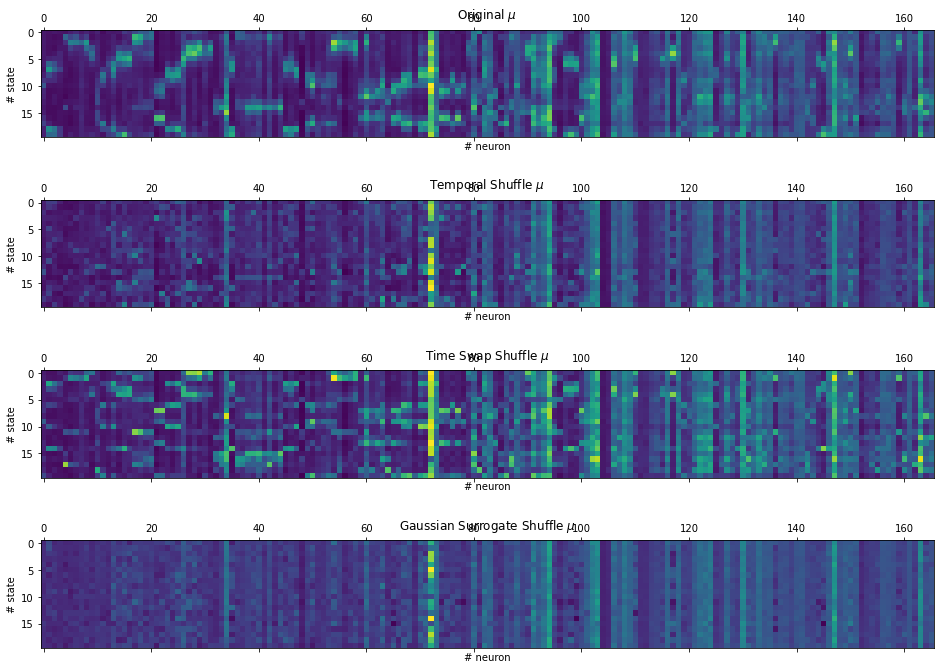

In [58]:
plt.figure(figsize=(16,12))
ax1 = plt.subplot(4,1,1)
ax1.matshow(origin.means_[order_ori.astype('int64') , :])
plt.xlabel('# neuron')
plt.ylabel('# state')
plt.title('Original $\mu$')

ax2 = plt.subplot(4,1,2)
ax2.matshow(TemS.means_[order_TemS.astype('int64') , :])
plt.xlabel('# neuron')
plt.ylabel('# state')
plt.title('Temporal Shuffle $\mu$')

ax3 = plt.subplot(4,1,3)
ax3.matshow(TSS.means_[order_TSS.astype('int64') , :])
plt.xlabel('# neuron')
plt.ylabel('# state')
plt.title('Time Swap Shuffle $\mu$')

ax4 = plt.subplot(4,1,4)
ax4.matshow(GSS.means_[order_GSS.astype('int64') , :])
plt.xlabel('# neuron')
plt.ylabel('# state')
plt.title('Gaussian Surrogate Shuffle $\mu$')

plt.show()

### 3.2. Sparsity and Connectivity
As definition, Gigi coefficient can be computed as follows:
$$S(\mathbf{c})=1-2\sum_{k=1}^N\frac{c_{(k)}}{\Vert \mathbf{c} \Vert_1}\left( \frac{N-k+\frac{1}{2}}{N} \right)=\frac{\sum_i \sum_j |c_{(i)}-c_{(j)}|}{2\sum_i \sum_j c_{(j)}}=\left( \frac{\sum_i \sum_j |c_{(i)}-c_{(j)}|}{N^2}\right) \left(\frac{N}{2\sum_j c_{(j)}}\right)$$

In [47]:
def gini(x):
    return (np.abs(np.subtract.outer(x, x)).mean())/np.mean(x)/2

def Gini_transmat(n_components, mat):
    G = np.zeros(n_components)
    for i in range(n_components):
        G[i] = gini(mat[i,:])
    return G

In [59]:
n = origin.n_components

Gini_A_ori = Gini_transmat(n, origin.transmat_)
Gini_A_TemS = Gini_transmat(n, TemS.transmat_)
Gini_A_TSS = Gini_transmat(n, TSS.transmat_)
Gini_A_GSS = Gini_transmat(n, GSS.transmat_)

Gini_mu_ori = Gini_transmat(n, origin.means_)
Gini_mu_TemS = Gini_transmat(n, TemS.means_)
Gini_mu_TSS = Gini_transmat(n, TSS.means_)
Gini_mu_GSS = Gini_transmat(n, GSS.means_)

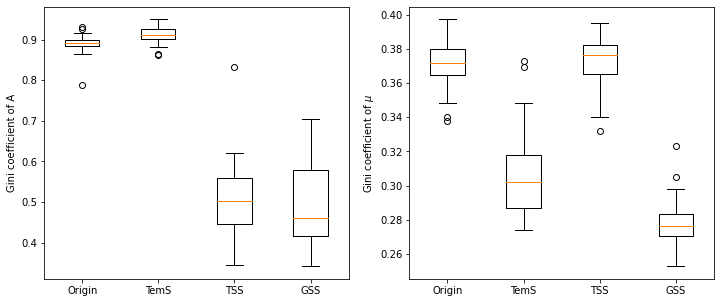

In [60]:
plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)
ax1.boxplot([Gini_A_ori,Gini_A_TemS,Gini_A_TSS,Gini_A_GSS])
plt.ylabel('Gini coefficient of A')
plt.xticks(np.arange(1,5), ['Origin', 'TemS', 'TSS', 'GSS'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot([Gini_mu_ori,Gini_mu_TemS,Gini_mu_TSS,Gini_mu_GSS])
plt.ylabel('Gini coefficient of $\mu$')
plt.xticks(np.arange(1,5), ['Origin', 'TemS', 'TSS', 'GSS'])
plt.show()

In [50]:
import nelpy.plotting.graph as npx

def plot_connect(transmat):
    Gi = npx.inner_graph_from_transmat(transmat)
    Go = npx.outer_graph_from_transmat(transmat)
    npx.draw_transmat_graph_inner(Gi, edge_threshold=0.0, lw=2, ec='k', node_size=3)
    npx.draw_transmat_graph_outer(Go, Gi, edge_threshold=0.0, lw=2, ec='k', nc='k', node_size=6)

/opt/anaconda3/lib/python3.8/site-packages/nelpy/plotting/decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


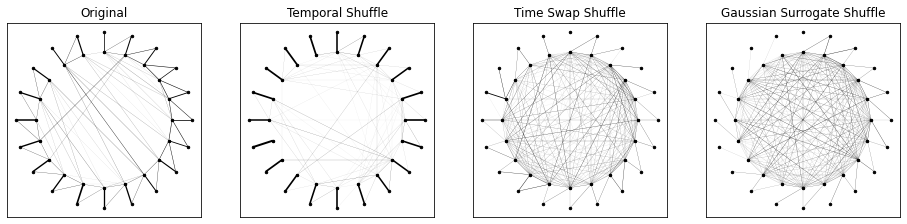

In [61]:
plt.figure(figsize=(16,12))
ax1 = plt.subplot(1,4,1)
plot_connect(T_ori)
plt.title('Original')
ax2 = plt.subplot(1,4,2)
plot_connect(T_TemS)
plt.title('Temporal Shuffle')
ax3 = plt.subplot(1,4,3)
plot_connect(T_TSS)
plt.title('Time Swap Shuffle')
ax4 = plt.subplot(1,4,4)
plot_connect(T_GSS)
plt.title('Gaussian Surrogate Shuffle')

plt.show()